In [116]:
import random
import argparse
import torch
import os

# seed 고정
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)

In [3]:
# 1. BERT계열 모델 사용
import transformers

# Reference : https://github.com/kyle-bong/K-TACC/tree/main
class BERT_aug():
    def __init__(self):
        self.model_name = "monologg/koelectra-base-v3-generator" # fill-mask Task에도 사용됨
        self.model = transformers.AutoModelForMaskedLM.from_pretrained(self.model_name)
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)
        self.unmasker = transformers.pipeline("fill-mask", model=self.model, tokenizer=self.tokenizer)

    def random_masking_insertion(self, sentence, ratio=0.15): # 랜덤하게 MASK를 삽입하고, MASK에 단어를 추가하는 것
        
        span = int(round(len(sentence.split()) * ratio)) # ratio 비율만큼 Masking할 단어 정하기
        mask = self.tokenizer.mask_token # Mask Token
        unmasker = self.unmasker # fill-mask Transformers Pipeline
        
        # Recover
        unmask_sentence = sentence # raw Sentence
        
        for _ in range(span): # Mask Token 마다
            unmask_sentence = unmask_sentence.split() # 단어별 split
            random_idx = random.randint(0, len(unmask_sentence)-1) # random으로 삽입될 idx 위치
            unmask_sentence.insert(random_idx, mask) # mask token을 random으로 선정된 위치에 
            unmask_sentence = unmasker(" ".join(unmask_sentence))[0]['sequence']

        unmask_sentence = unmask_sentence.replace("  ", " ")

        return unmask_sentence.strip()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BERT_augmentation = BERT_aug()
random_insertion = BERT_augmentation.random_masking_insertion

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
random_masking_test = random_insertion("글쎄.. 특색도 없고 별로였던 걸로 기억하는데..", 0.3)
print(random_masking_test)

. 글쎄.. 특색도 없고 별로였던 그런 걸로 기억하는데..


In [5]:
import pandas as pd

# nsmc-sampled, petition-sampled, slack-sampled
train_data = pd.read_csv("../../data/train_preprocess_v1.csv")
sample_source = train_data
train_source = sample_source[["id","source","sentence_1","sentence_2","label","binary-label"]]
train_source

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고, 사랑도 있고 재미도 있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택 기준 변경해 주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야 합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부의 폐지를 원합 니드,여성가족부 폐지를 청원합니다.,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,국회의원들 월급 좀 줄여주세요,공무원 봉급 좀 줄이지 좀 마세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못한 점심은 다음에 다시 트라이 하기로 해요!!,오늘 못 먹은 밥은 꼭 담에 먹기로 하고요!!,3.2,1.0


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50521 (\N{HANGUL SYLLABLE ANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

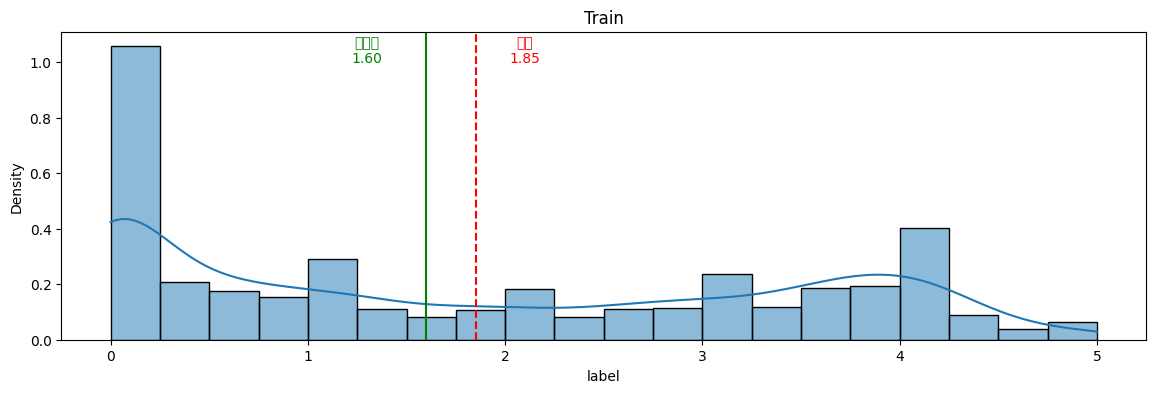

In [117]:
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
# label 히스토그램 시각화
def label_histogram(data, title, ax):
    mean = data['label'].mean()
    median = data['label'].median()
    
    sns.histplot(data=data, x='label', stat='density', binwidth=0.25, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Density')
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean + 0.25, ax.get_ylim()[1] * 0.9, f'평균\n{mean:.2f}', color='r', ha='center')
    ax.axvline(median, color='g', linestyle='-', label='Median')
    ax.text(median - 0.3, ax.get_ylim()[1] * 0.9, f'중앙값\n{median:.2f}', color='g', ha='center')

# label별 히스토그램 시각화
fig, axes = plt.subplots(1, 1, figsize=(14, 4))
label_histogram(sample_source, 'Train', axes)
max_y = max(axes.get_ylim())
axes.set_ylim(0, max_y)
plt.show()

In [11]:
sample_source = sample_source[sample_source["label"] > 1]
sample_source = sample_source[["id","source","sentence_1","sentence_2","label","binary-label"]]
sample_source
def transform_sentence(columns, ratio=0.2):
    transformed_sen = []
    for sentence in columns:
        random_masking_test = random_insertion(sentence, ratio)
        transformed_sen.append(random_masking_test)
    return transformed_sen


sentences_1 = transform_sentence(sample_source["sentence_1"], ratio=0.25)
sentences_2 = transform_sentence(sample_source["sentence_2"], ratio=0.25)

In [12]:
lab = sample_source["label"]
binary_lab = sample_source["binary-label"]
ids = ["boostcamp-sts-v1-train-aug-bert-"+str(i) for i in range(len(sentences_1))]
sources = [source+"-bert-aug" for source in sample_source["source"]]

In [13]:
sen2 = sample_source["sentence_2"]
lab = sample_source["label"]
df2 = pd.DataFrame(zip(sen2, sentences_2, lab))
df2.columns=["Sentence2", "transform","label"]

In [14]:
df2

,Sentence2,transform,label
0,"반전도 있고, 사랑도 있고 재미도 있네요.","반전도 있고, 반전 사랑도 매력 있고 재미도 있네요.",2.2
1,"오, 액세스 권한이 없다고 합니다.","오, 인터넷 액세스 권한이 없다고 합니다.",4.2
2,주택청약 무주택 기준 변경해 주세요.,주택청약시 무주택 기준 변경해 주세요.,2.4
3,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,화상으로만 보다가 이렇게 리얼로 만나니 정말이지 반가웠습니다.,3.0
4,오 마이 갓 지저스 스트론 이스트 팬,오 마이 마이 갓 지저스 스트론 이스트우드 팬,2.6
...,...,...,...
5266,동물원 법을 강화시켜 주세요,청소년 동물원 법을 강화시켜 주세요,1.5
5267,Warmad 회원에 대한 테러 방지법 적용을 검토하십시오.,Warmad 회원에 대한 테러 및 테러 방지법 적용을 검토하십시오.,4.4
5268,여성가족부 폐지를 청원합니다.,그리고 여성가족부 폐지를 청원합니다.,4.2
5269,오늘 못 먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못 먹은 밥은 꼭 이 밥 담에 먹기로 하고요!!,3.2


In [15]:
df = pd.DataFrame(zip(ids, sources, sentences_1, sentences_2, lab, binary_lab))
df.columns=sample_source.columns

In [16]:
df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-aug-bert-0,nsmc-sampled-bert-aug,"스릴도 있고 반전도 매력 있고, 여느 한국 영화 쓰레기들하고는 차원이 다르네요 ~","반전도 있고, 반전 사랑도 매력 있고 재미도 있네요.",2.2,0.0
1,boostcamp-sts-v1-train-aug-bert-1,slack-rtt-bert-aug,앗! 제가 여기 접근 권한이 없다고 뜹니다 ; ;,"오, 인터넷 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-aug-bert-2,petition-sampled-bert-aug,주택청약조건 변경해 봐 주세요.,주택청약시 무주택 기준 변경해 주세요.,2.4,0.0
3,boostcamp-sts-v1-train-aug-bert-3,slack-sampled-bert-aug,회사 입사 후 처음 대면으로 처음 만나 반가웠습니다.,화상으로만 보다가 이렇게 리얼로 만나니 정말이지 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-aug-bert-4,nsmc-rtt-bert-aug,오마이가뜨지져스크롸이스트휏,오 마이 마이 갓 지저스 스트론 이스트우드 팬,2.6,1.0
...,...,...,...,...,...,...
5266,boostcamp-sts-v1-train-aug-bert-5266,petition-sampled-bert-aug,동물보호법을 강화해 해 주세요,청소년 동물원 법을 강화시켜 주세요,1.5,0.0
5267,boostcamp-sts-v1-train-aug-bert-5267,petition-rtt-bert-aug,워마드 회원 회원에 대해 테러방지법 적용을 적극 검토해 주세요.,Warmad 회원에 대한 테러 및 테러 방지법 적용을 검토하십시오.,4.4,1.0
5268,boostcamp-sts-v1-train-aug-bert-5268,petition-sampled-bert-aug,여성가족부의 폐지를 위한 원합 니드,그리고 여성가족부 폐지를 청원합니다.,4.2,1.0
5269,boostcamp-sts-v1-train-aug-bert-5269,slack-sampled-bert-aug,오늘 못한 점심은 다음에 다시 트라이아웃 하기로 했으면 해요!!,오늘 못 먹은 밥은 꼭 이 밥 담에 먹기로 하고요!!,3.2,1.0


In [23]:
concat_df = pd.concat([train_source, df])
concat_df.reset_index(drop=True, inplace=True)

In [24]:
concat_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고, 사랑도 있고 재미도 있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택 기준 변경해 주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0
...,...,...,...,...,...,...
14590,boostcamp-sts-v1-train-aug-bert-5266,petition-sampled-bert-aug,동물보호법을 강화해 해 주세요,청소년 동물원 법을 강화시켜 주세요,1.5,0.0
14591,boostcamp-sts-v1-train-aug-bert-5267,petition-rtt-bert-aug,워마드 회원 회원에 대해 테러방지법 적용을 적극 검토해 주세요.,Warmad 회원에 대한 테러 및 테러 방지법 적용을 검토하십시오.,4.4,1.0
14592,boostcamp-sts-v1-train-aug-bert-5268,petition-sampled-bert-aug,여성가족부의 폐지를 위한 원합 니드,그리고 여성가족부 폐지를 청원합니다.,4.2,1.0
14593,boostcamp-sts-v1-train-aug-bert-5269,slack-sampled-bert-aug,오늘 못한 점심은 다음에 다시 트라이아웃 하기로 했으면 해요!!,오늘 못 먹은 밥은 꼭 이 밥 담에 먹기로 하고요!!,3.2,1.0


In [27]:
concat_df.to_csv("./train_bertaug_25.csv")

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50521 (\N{HANGUL SYLLABLE ANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

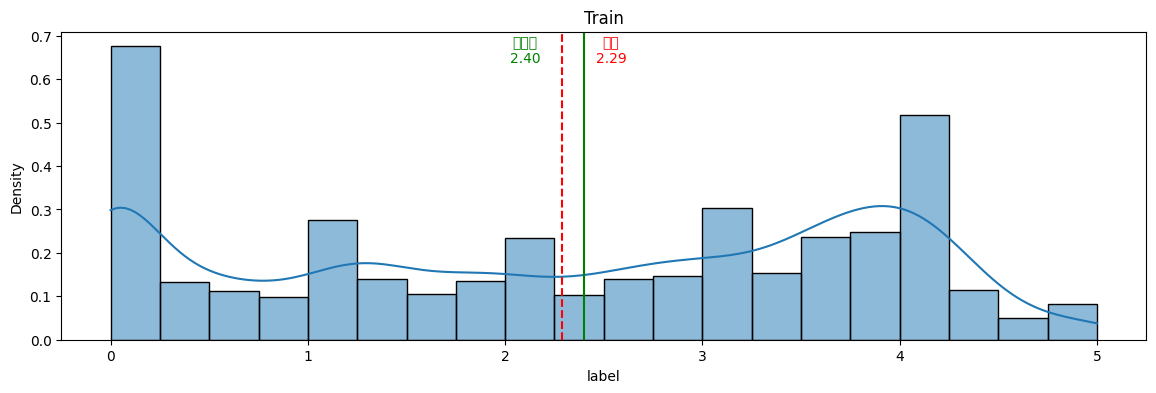

In [26]:
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
# label 히스토그램 시각화
def label_histogram(data, title, ax):
    mean = data['label'].mean()
    median = data['label'].median()
    
    sns.histplot(data=data, x='label', stat='density', binwidth=0.25, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Density')
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean + 0.25, ax.get_ylim()[1] * 0.9, f'평균\n{mean:.2f}', color='r', ha='center')
    ax.axvline(median, color='g', linestyle='-', label='Median')
    ax.text(median - 0.3, ax.get_ylim()[1] * 0.9, f'중앙값\n{median:.2f}', color='g', ha='center')

# label별 히스토그램 시각화
fig, axes = plt.subplots(1, 1, figsize=(14, 4))
label_histogram(concat_df, 'Train', axes)
max_y = max(axes.get_ylim())
axes.set_ylim(0, max_y)
plt.show()

In [16]:

print(len(train_source[(train_source["label"] >= 0.0) & (train_source["label"] < 1.0)]))
print(len(train_source[(train_source["label"] >= 1.0) & (train_source["label"] < 2.0)]))
print(len(train_source[(train_source["label"] >= 2.0) & (train_source["label"] < 3.0)]))
print(len(train_source[(train_source["label"] >= 3.0) & (train_source["label"] < 4.0)]))
print(len(train_source[(train_source["label"] >= 4.0) & (train_source["label"] <= 5.0)]))

3711
1368
1137
1715
1393


In [94]:
# 2. Sentence Swap
import pandas as pd
data_train = pd.read_csv("../../data/train_preprocess_v1.csv")
data_train = data_train.drop(columns=["Unnamed: 0"])
def swap_sentence(df: pd.DataFrame) -> pd.DataFrame:
    """Sentence1과 Sentence2를 Swap하는 함수"""
    df_swapped = df.copy()

    # 조건에 맞는 데이터만 선택
    # mask = ((df['label'] >= 0.5) & (df['label'] < 3.5)) | ((df['label'] >= 4.5) & (df['label'] < 5))
    mask = (df["label"] >= 3.0)
    df_swapped.loc[mask, ['sentence_1', 'sentence_2']] = df_swapped.loc[mask, ['sentence_2', 'sentence_1']].values

    return df_swapped

# Random Swap 적용
data_swapped = swap_sentence(data_train)

# label이 3이하인 값을 제거
data_swapped_nonzero = data_swapped[data_swapped['label'] > 3.0]
swap_source = []
for i, source in enumerate(data_swapped_nonzero["source"]):
    # data_swapped_nonzero.iloc[i]["source"] = source + "-swaped"
    swap_source.append(source+"-swaped")
data_swapped_nonzero["source"] = swap_source

# 데이터 합치기
combined_data = pd.concat([data_train, data_swapped_nonzero], ignore_index=True)

# 결과 출력
print(f"원본 데이터 수: {data_train.shape[0]}")
print(f"스왑된 데이터 수 (label 3.0 이하 제거): {data_swapped_nonzero.shape[0]}")
print(f"합친 데이터 수: {combined_data.shape[0]}")


원본 데이터 수: 9324
스왑된 데이터 수 (label 3.0 이하 제거): 2825
합친 데이터 수: 12149


/tmp/ipykernel_1078648/3184137924.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_swapped_nonzero["source"] = swap_source


In [95]:
combined_data

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고, 사랑도 있고 재미도 있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택 기준 변경해 주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0
...,...,...,...,...,...,...
12144,boostcamp-sts-v1-train-9310,petition-sampled-swaped,음주운전 처벌 강화해 주세요,음주운전 처벌 강화,4.0,1.0
12145,boostcamp-sts-v1-train-9314,petition-sampled-swaped,박상기 법무장관 해임 바랍니다,박상기 현 법무부 장관 해임,3.8,1.0
12146,boostcamp-sts-v1-train-9318,petition-rtt-swaped,Warmad 회원에 대한 테러 방지법 적용을 검토하십시오.,워마드 회원에 대해 테러방지법 적용을 검토해 주세요.,4.4,1.0
12147,boostcamp-sts-v1-train-9320,petition-sampled-swaped,여성가족부 폐지를 청원합니다.,여성가족부의 폐지를 원합 니드,4.2,1.0


In [70]:
combined_data.to_csv("../../data/train_Swaped.csv")

In [123]:
# Back Translation
bt_data = pd.read_csv("../../data/train_BT.csv")
bt_source = []
for i, source in enumerate(bt_data["source"]):
    # data_swapped_nonzero.iloc[i]["source"] = source + "-swaped"
    bt_source.append(source+"-BT")
bt_data["source"] = bt_source

In [124]:
bt_data[bt_data["label"] > 0.5]

,id,source,sentence_1,sentence_2,label,binary_label
0,boostcamp-sts-v1-train-9319,nsmc-sampled-BT,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전, 사랑과 재미가 있습니다.",2.2,0.0
1,boostcamp-sts-v1-train-9320,slack-sampled-BT,입사 후 처음 대면으로 만나 반가웠습니다.,화상에서만 만나고 진짜를 만났습니다.,3.0,1.0
3,boostcamp-sts-v1-train-9322,nsmc-sampled-BT,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이것은 이와 같은 첫 번째 공포 영화입니다.,0.6,0.0
4,boostcamp-sts-v1-train-9323,nsmc-sampled-BT,극의 전개가 너무 느릿하여 답답합니다,개발이 너무 느려서 터져 나옵니다,3.8,1.0
5,boostcamp-sts-v1-train-9324,nsmc-sampled-BT,글쎄.. 특색도 없고 별로였던 걸로 기억하는데..,나는 큰 반전이 없다는 것을 기억합니다 ...,1.8,0.0
...,...,...,...,...,...,...
4310,boostcamp-sts-v1-train-13629,nsmc-sampled-BT,너무 재미있게 봤습니다. 추천,나는 영화를 너무 많이 보았다.,3.4,1.0
4312,boostcamp-sts-v1-train-13631,nsmc-sampled-BT,별로~에 잉~~시간 매우 아깝다~,ehyo.time은 폐기물입니다.,3.6,1.0
4315,boostcamp-sts-v1-train-13634,slack-sampled-BT,"얘기하다 보니 피플팀 업무 얘기도 잠깐 나왔었는데요, 정말 많은 것들을 케어해주고 ...","나는 콘텐츠 팀에서 내가하고있는 일, 인턴쉽 시절에 느꼈던 것, 팁에 대한 이야기에...",0.6,0.0
4318,boostcamp-sts-v1-train-13637,slack-sampled-BT,어쩌다 보니 사람 들어간 사진은 못 찍었는데 너무 맛있었고 재밌었습니다!!,너무 맛있어서 다시 가고 싶어 !!,1.6,0.0


In [125]:
data_train = pd.read_csv("../../data/train_preprocess_v1.csv")
data_train = data_train.drop(columns=["Unnamed: 0"])
combined_bt = pd.concat([data_train, bt_data], ignore_index=True)
combined_bt.to_csv("../../train_bt_only.csv")

In [96]:
combined_swap_bt = pd.concat([combined_data, bt_data], ignore_index=True)

In [97]:
combined_swap_bt.to_csv("../../data/train_swaped_bt.csv")

In [110]:
bert_data = pd.read_csv("../../data/bert_aug.csv")
bert_data.drop(columns=["Unnamed: 0"], inplace=True)
swap_bt_train = pd.read_csv("../../data/train_swaped_bt.csv")
combined_bert_bt_swap = pd.concat([swap_bt_train, bert_data], ignore_index=True)
combined_bert_bt_swap.drop(columns=["Unnamed: 0"], inplace=True)
combined_bert_bt_swap.to_csv("../../data/train_bt_swap_bert.csv")

In [111]:
combined_bert_bt_swap["source"].unique()

array(['nsmc-sampled', 'slack-rtt', 'petition-sampled', 'slack-sampled',
       'nsmc-rtt', 'petition-rtt', 'slack-rtt-swaped',
       'petition-sampled-swaped', 'nsmc-sampled-swaped',
       'nsmc-rtt-swaped', 'petition-rtt-swaped', 'slack-sampled-swaped',
       'nsmc-sampled-BT', 'slack-sampled-BT', 'slack-rtt-bert-aug',
       'petition-sampled-bert-aug', 'nsmc-sampled-bert-aug',
       'nsmc-rtt-bert-aug', 'petition-rtt-bert-aug',
       'slack-sampled-bert-aug'], dtype=object)

In [112]:
combined_bert_bt_swap

,id,source,sentence_1,sentence_2,label,binary-label,binary_label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고, 사랑도 있고 재미도 있네요.",2.2,0.0,NaN
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0,NaN
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택 기준 변경해 주세요.,2.4,0.0,NaN
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0,NaN
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0,NaN
...,...,...,...,...,...,...,...
19289,boostcamp-sts-v1-train-aug-bert-2820,petition-sampled-bert-aug,음주운전 처벌 강화,제발 음주운전 처벌 강화해 주세요,4.0,1.0,NaN
19290,boostcamp-sts-v1-train-aug-bert-2821,petition-sampled-bert-aug,박상기 현 법무부 법무부 장관 해임,박상기 법무장관의 해임 바랍니다,3.8,1.0,NaN
19291,boostcamp-sts-v1-train-aug-bert-2822,petition-rtt-bert-aug,그리고 워마드 회원에 대해 테러방지법 적용을 검토해 주세요.,Warmad 회원에 대한 테러 방지법의 적용을 검토하십시오.,4.4,1.0,NaN
19292,boostcamp-sts-v1-train-aug-bert-2823,petition-sampled-bert-aug,- 여성가족부의 폐지를 원합 니드,여성가족부 폐지를 청원합니다.,4.2,1.0,NaN


In [113]:
bert_data = pd.read_csv("../../data/bert_aug.csv")
bert_data.drop(columns=["Unnamed: 0"], inplace=True)
swap_train = pd.read_csv("../../data/train_Swaped.csv")
combined_bert_swap = pd.concat([swap_train, bert_data], ignore_index=True)
combined_bert_swap.drop(columns=["Unnamed: 0"], inplace=True)
combined_bert_swap.to_csv("../../data/train_bert_swap.csv")

In [114]:
combined_bert_swap

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고, 사랑도 있고 재미도 있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택 기준 변경해 주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0
...,...,...,...,...,...,...
14969,boostcamp-sts-v1-train-aug-bert-2820,petition-sampled-bert-aug,음주운전 처벌 강화,제발 음주운전 처벌 강화해 주세요,4.0,1.0
14970,boostcamp-sts-v1-train-aug-bert-2821,petition-sampled-bert-aug,박상기 현 법무부 법무부 장관 해임,박상기 법무장관의 해임 바랍니다,3.8,1.0
14971,boostcamp-sts-v1-train-aug-bert-2822,petition-rtt-bert-aug,그리고 워마드 회원에 대해 테러방지법 적용을 검토해 주세요.,Warmad 회원에 대한 테러 방지법의 적용을 검토하십시오.,4.4,1.0
14972,boostcamp-sts-v1-train-aug-bert-2823,petition-sampled-bert-aug,- 여성가족부의 폐지를 원합 니드,여성가족부 폐지를 청원합니다.,4.2,1.0


In [122]:
combined_bt_bert = pd.concat([combined_bt, bert_data], ignore_index=True)
combined_bt_bert.to_csv("../../train_bt_bert.csv")

In [121]:
combined_bt_bert

,id,source,sentence_1,sentence_2,label,binary-label,binary_label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고, 사랑도 있고 재미도 있네요.",2.2,0.0,NaN
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0,NaN
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택 기준 변경해 주세요.,2.4,0.0,NaN
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0,NaN
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0,NaN
...,...,...,...,...,...,...,...
16464,boostcamp-sts-v1-train-aug-bert-2820,petition-sampled-bert-aug,음주운전 처벌 강화,제발 음주운전 처벌 강화해 주세요,4.0,1.0,NaN
16465,boostcamp-sts-v1-train-aug-bert-2821,petition-sampled-bert-aug,박상기 현 법무부 법무부 장관 해임,박상기 법무장관의 해임 바랍니다,3.8,1.0,NaN
16466,boostcamp-sts-v1-train-aug-bert-2822,petition-rtt-bert-aug,그리고 워마드 회원에 대해 테러방지법 적용을 검토해 주세요.,Warmad 회원에 대한 테러 방지법의 적용을 검토하십시오.,4.4,1.0,NaN
16467,boostcamp-sts-v1-train-aug-bert-2823,petition-sampled-bert-aug,- 여성가족부의 폐지를 원합 니드,여성가족부 폐지를 청원합니다.,4.2,1.0,NaN
